In [ ]:
import os
import zipfile
from PIL import Image
from glob import glob
import re
import random

import torch
from torchvision import transforms
import h5py
import matplotlib.pyplot as plt
import numpy as np
import kornia.augmentation as K

from src.config import Directories

In [2]:
data_dir = Directories.PULMONARY_CXR_ABNORMALITIES
if not os.path.exists(os.path.join(data_dir, 'train.hdf5')):
    from dataset import create_cxr_hdf5
    create_cxr_hdf5(os.path.join(Directories.DATA), out_dir_name='pulmonary_cxr_abnormalities')

hf_fp = os.path.join(data_dir, 'train.hdf5')
hf_train = h5py.File(hf_fp, 'r+')
hf_fp = os.path.join(data_dir, 'test.hdf5')
hf_test = h5py.File(hf_fp, 'r+')

Total number of input images: 279

    Input Image:
    	 Shape: (1024, 1024, 3)
    	 Dtype: uint8
    	 Min and Max Values: [0, 255]

    Target Image:
    	 Shape: (1024, 1024)
    	 Dtype: uint8
    	 Min and Max Values: [0, 1]    



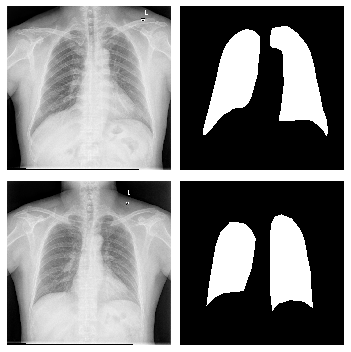

In [3]:
num_images = len(hf_train['shenzhen/healthy/cxr']) + len(hf_test['shenzhen/healthy/cxr'])
image = hf_train['shenzhen']['healthy']['cxr'][0]
target = hf_train['shenzhen']['healthy']['masks'][0]

print(f"""Total number of input images: {num_images}

    Input Image:
    \t Shape: {image.shape}
    \t Dtype: {image.dtype}
    \t Min and Max Values: [{image.min()}, {image.max()}]

    Target Image:
    \t Shape: {target.shape}
    \t Dtype: {target.dtype}
    \t Min and Max Values: [{target.min()}, {target.max()}]    
""")

idx = 0
image1 = hf_train['shenzhen']['healthy']['cxr'][idx]
mask1 = hf_train['shenzhen']['healthy']['masks'][idx]

idx = 1
image2 = hf_train['shenzhen']['healthy']['cxr'][idx]
mask2 = hf_train['shenzhen']['healthy']['masks'][idx]

plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
plt.imshow(image1, cmap="gray")
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(mask1, cmap="gray")
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image2, cmap="gray")
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(mask2, cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.show()

# Data Preprocess
1. Binarize pixel values to 0, 1 (negative and positive lung labels)

In [4]:
target_dataset = hf_train['shenzhen/healthy/masks']
if target_dataset[0].max() == 255:
    for i, target in enumerate(target_dataset):
        hf_train['shenzhen/healthy/masks'][i] = target//255

    target_dataset = hf_test['shenzhen/healthy/masks']
    for i, target in enumerate(target_dataset):
        hf_test['shenzhen/healthy/masks'][i] = target//255

# Target Label Distribution

In [40]:
target_dataset = hf_train['shenzhen/healthy/masks']
_, counts = np.unique(target_dataset, return_counts=True)
distribution = np.asarray([counts[0]/sum(counts), counts[1]/sum(counts)])

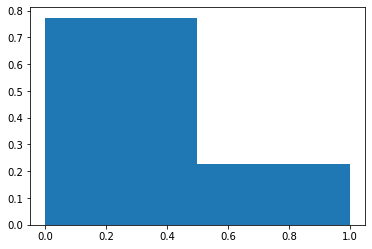

In [57]:
plt.hist([0, 1], bins=2, weights=distribution)
plt.show()

In [45]:
# hf_train.create_dataset('shenzhen/healthy/target_count', data=counts)
# hf_train.create_dataset('shenzhen/healthy/target_distribution', data=distribution)

<HDF5 dataset "target_distribution": shape (2,), type "<f8">

# Data Augmentation

In [5]:
cxr_dataset = hf_train['shenzhen/healthy/cxr']
target_dataset = hf_train['shenzhen/healthy/masks']

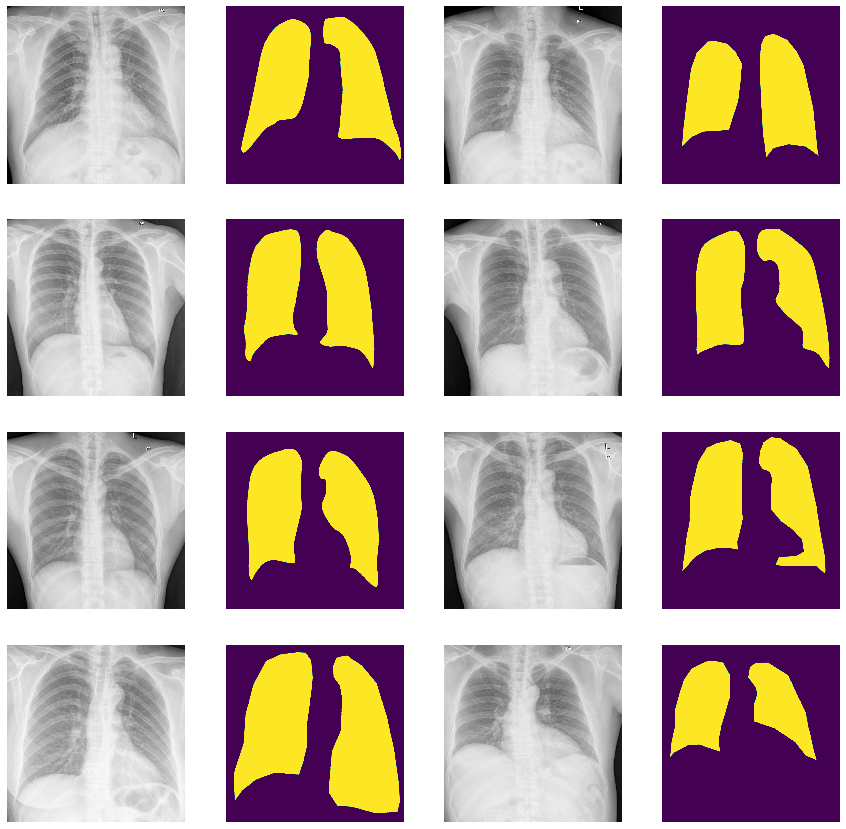

In [6]:
rows, cols = 4, 4

height, width, _ = cxr_dataset[0].shape
crop_size = int(height * 0.85)

cc = transforms.Compose([
    transforms.ToTensor(),
    K.RandomAffine(0, shear=(-5, 5)),
    K.RandomHorizontalFlip(),
    K.CenterCrop((crop_size, crop_size)),
])
seed = np.random.randint(2147483647)

images = cxr_dataset[:rows*cols//2]
targets = target_dataset[:rows*cols//2]

i=0
j=1
plt.figure(figsize=(15,15))
for row in range(rows):
    for col in range(0, cols, 2):
        
        image = cxr_dataset[i]
        target = target_dataset[i]
        
        random.seed(seed)
        torch.manual_seed(seed)
        t_image = cc(image)

        random.seed(seed)
        torch.manual_seed(seed)
        t_target = cc(target)

        plt.subplot(rows, cols, j)
        plt.imshow(t_image.cpu().squeeze().permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.subplot(rows, cols, j+1)
        plt.imshow(t_target.cpu().squeeze().numpy())
        plt.axis('off')
        i+=1
        j+=2